# Vectorized Linear Regression

In [1]:
import numpy as np
np.random.seed(42)
np.set_printoptions(precision=10, suppress=True)

import pandas as pd

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

import timeit

## Data Generation

In [2]:
n = 50
X = np.random.random((n, 1))
X = sm.add_constant(X)
beta = [200, 100]
e = np.random.random(n) * 25
y = np.dot(X, beta) + e


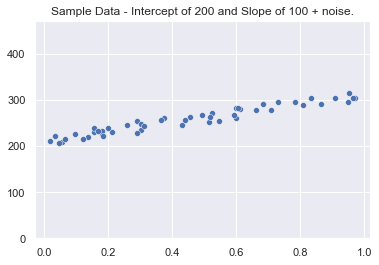

In [3]:
ax = sns.scatterplot(x=X[:,1], y=y)
ax.set_ylim(0, np.max(y) * 1.5)
ax.set_title(f'Sample Data - Intercept of {beta[0]:.0f} and Slope of {beta[1]:.0f} + noise.')
plt.show()

## Statsmodels OLS
https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html

In [4]:
fit = sm.OLS(y, X).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     706.1
Date:                Fri, 19 Nov 2021   Prob (F-statistic):           2.31e-30
Time:                        20:13:07   Log-Likelihood:                -172.22
No. Observations:                  50   AIC:                             348.4
Df Residuals:                      48   BIC:                             352.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        211.6243      2.026    104.430      0.000     207.550     215.699
x1           101.6519      3.825     26.573      0.000      93.961     109.343
==============================================================================
Omnibus:                       22.772   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                3.905
Skew:                          -0.068   Prob(JB):                        0.142
Kurtosis:                       1.638   Cond. No.                         4.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Numpy (Arithmetic) for Simple Linear Regression
For one variable we can use simple arithmetic and numpy for vectorization. The formula is as follows and you'll see this mapped directly more or less to numpy operations.

### $ \frac { \sum\limits_{i=1}^{n} (x_i - \bar x) (y_i - \bar y)} {\sum\limits_{i=1}^{n} (x_i - \bar x)^2} $

In [5]:
x = X[:,1]
slope = np.dot(x - x.mean(), y - y.mean()) / np.dot(x - x.mean(), x - x.mean())
intercept = y.mean() - slope*x.mean()
print(f'Simple linear regression arithmetic slope of {slope:.2f} vs. statsmodels ols fit slope of {fit.params[1]:.2f}.')
print(f'Results equal: {np.allclose(slope,fit.params[1])}')

Simple linear regression arithmetic slope of 101.65 vs. statsmodels ols fit slope of 101.65.
Results equal: True


## Matrix Formulation
Some reference if interested in the particulars: 

https://economictheoryblog.com/2015/02/19/ols_estimator/

### $ {(X^TX)}^{-1} X^Ty $

In [6]:
matrix_intercept, matrix_slope = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)), X.T), y)

In [7]:
df = pd.DataFrame([
    {'Method': 'statsmodels', 'Intercept': fit.params[0], 'Slope': fit.params[1]},
    {'Method': 'SLR Arithmetic Formula', 'Intercept': intercept, 'Slope': slope},
    {'Method': 'Matrix Formula', 'Intercept': matrix_intercept, 'Slope': matrix_slope}
])
df

,Method,Intercept,Slope
0,statsmodels,211.624311,101.651916
1,SLR Arithmetic Formula,211.624311,101.651916
2,Matrix Formula,211.624311,101.651916


In [8]:
print(f'Same Intercepts: {len(set(df.Intercept.values.round(10))) == 1}')
print(f'Same Slopes: {len(set(df.Slope.values.round(10))) == 1}')

Same Intercepts: True
Same Slopes: True


## Multiple Regressions at once

## $ \forall k \in \{1 \dots n \} {(X^T_k X_k)}^{-1} X^T_k y_k $
### where $ n \equiv $ number of regressions

This can be read as: for all k to n regressions, perform matrix form ols...

### New Data Gen - Two Regressions, Now with 2 regressors + Intercept

In [9]:
n = 50
X = np.random.random((n, 2))
X = sm.add_constant(X)
beta = [200, 100, 50]
e = np.random.random(n) * 25
y = np.dot(X, beta) + e

X2 = np.random.random((n, 2))
X2 = sm.add_constant(X2)
beta2 = [500, 10, 5]
e2 = np.random.random(n) * 5
y2 = np.dot(X2, beta2) + e

In [10]:
X_many = np.array([X, X2])
y_many = np.array([y, y2])

print(X_many.shape)
print(y_many.shape)

(2, 50, 3)
(2, 50)


### Standard OLS approach for each

In [11]:
try:
    sm.OLS(y_many, X_many).fit()
except ValueError:
    print('Stats Model OLS function would not run on 3d data.')

Stats Model OLS function would not run on 3d data.


In [12]:
fit_a = sm.OLS(y_many[0], X_many[0]).fit()
fit_b = sm.OLS(y_many[1], X_many[1]).fit()
print(f'Intercept/Slopes of {*fit_a.params,} and {*fit_b.params,}.')

Intercept/Slopes of (209.92404133746055, 95.32548234874625, 61.4157238175172) and (514.1649366640229, 8.135532283891308, 4.335316267085091).


### We'll need a new way to transpose

In [13]:
# We can't rely on simple .T for transpose anymore...we only want our transpose to change the last two dimensions.
print(X_many.T.shape)

# We'll need to transpose with the function and specify exactly what we want to get the right shape
X_many.transpose(0,2,1).shape

(3, 50, 2)


(2, 3, 50)

### Now back to matrix formula with this added dimension account for

In [14]:
x_operations = np.matmul(np.linalg.inv(np.matmul(X_many.transpose(0,2,1),X_many)), X_many.transpose(0,2,1))
m_solve = np.matmul(x_operations, y_many[..., np.newaxis])[...,0]
m_solve

array([[209.9240413375,  95.3254823487,  61.4157238175],
       [514.164936664 ,   8.1355322839,   4.3353162671]])

In [15]:
# Check that first regression returned the same results
np.allclose(np.array(fit_a.params), m_solve[0])

True

In [16]:
# Check that second regression returned the same results
np.allclose(np.array(fit_b.params), m_solve[1])

True

### Einsum Version
For fun, let's do the same with einsum notation.

More Information: https://numpy.org/doc/stable/reference/generated/numpy.einsum.html

In [17]:
# Step 1: inv of XXt
step1 = np.linalg.inv(np.einsum('ikj,ikl->ijl', X_many, X_many))
# Step 2: Above operation matmul Xt
step2 = np.einsum('ijk,ilk->ijl', step1, X_many)
# Step 3: Above operation matmul y
einsum_solve = np.einsum('ijk,ik->ij', step2, y_many)
# Print Results
print(einsum_solve)

[[209.9240413375  95.3254823487  61.4157238175]
 [514.164936664    8.1355322839   4.3353162671]]


In [18]:
# Check that matrix multiplication and einsum approach are the same
np.allclose(m_solve, einsum_solve)

True

### Statsmodel Loop

In [19]:
def np_to_df(X_many_orig, y_many_orig):
    '''Helper method for this simple example, changing x/y numpy arrays for 2 regressor ols into a df'''
    # Reshape x into 2d
    a, b, c = X_many_orig.shape
    regression_number = np.repeat(np.arange(a),b)
    td_array = np.reshape(X_many_orig, (a*b,-1))
    stacked_arr = np.column_stack([regression_number, td_array])

    # Combine into DF with y
    df = pd.DataFrame(stacked_arr)
    column_list = ['regression_number', 'intercept', 'regressor_1', 'regressor_2']
    df.columns = column_list
    df['y'] = np.reshape(y_many_orig, -1)

    return df

In [20]:
# Numpy to df conversion, and show a few records
df = np_to_df(X_many, y_many)
df.head()

,regression_number,intercept,regressor_1,regressor_2,y
0,0.0,1.0,0.031429,0.636410,251.014230
1,0.0,1.0,0.314356,0.508571,258.967632
2,0.0,1.0,0.907566,0.249292,307.261977
3,0.0,1.0,0.410383,0.755551,301.279704
4,0.0,1.0,0.228798,0.076980,241.889539


In [21]:
def run_sm_ols(df_grouping):
    # Run statsmodel ols
    ols_results = sm.OLS(df_grouping.loc[:,'y'], df_grouping.loc[:, ['intercept', 'regressor_1', 'regressor_2']]).fit()
    # Unpack variables
    intercept, b1, b2 = ols_results.params
    # Return to apply call as a series (3 separate columns)
    return pd.Series([intercept, b1, b2], index=['intercept', 'b1', 'b2'])

In [22]:
# For each regression we are attempting to do in parallel, run the run_sm_ols function
df.groupby('regression_number').apply(run_sm_ols)

,intercept,b1,b2
regression_number,,,
0.0,209.924041,95.325482,61.415724
1.0,514.164937,8.135532,4.335316


### Comparing Speeds

In [23]:
def get_random_x_y():
    '''Helper function for returning a single multiple x/y pair for random regressions'''
    n = 50
    X = np.random.random((n, 2))
    X = sm.add_constant(X)
    beta = [np.random.randint(175, 200), np.random.randint(90, 100), np.random.randint(40,50)]
    e = np.random.random(n) * 25
    y = np.dot(X, beta) + e
    return X, y

# Build a bunch of random regressions
multiple_regressions = [get_random_x_y() for i in range(100)]
X_many = np.array([x for x,y in multiple_regressions])
y_many = np.array([y for x,y in multiple_regressions])
df = np_to_df(X_many, y_many)

In [24]:
%%timeit -r 10 -n 1000
x_operations = np.matmul(np.linalg.inv(np.matmul(X_many.transpose(0,2,1),X_many)), X_many.transpose(0,2,1))
m_solve = np.matmul(x_operations, y_many[..., np.newaxis])[...,0]

151 µs ± 5.9 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [25]:
%%timeit -r 10 -n 1000
step1 = np.linalg.inv(np.einsum('ikj,ikl->ijl', X_many, X_many))
step2 = np.einsum('ijk,ilk->ijl', step1, X_many)
einsum_solve = np.einsum('ijk,ik->ij', step2, y_many)

650 µs ± 17.3 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [26]:
%%timeit -r 10 -n 1000
df_solve = df.groupby('regression_number').apply(run_sm_ols)

120 ms ± 16.8 ms per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [27]:
# Verify same

# Matmul
x_operations = np.matmul(np.linalg.inv(np.matmul(X_many.transpose(0,2,1),X_many)), X_many.transpose(0,2,1))
m_solve = np.matmul(x_operations, y_many[..., np.newaxis])[...,0]

# Einsum
step1 = np.linalg.inv(np.einsum('ikj,ikl->ijl', X_many, X_many))
step2 = np.einsum('ijk,ilk->ijl', step1, X_many)
einsum_solve = np.einsum('ijk,ik->ij', step2, y_many)

# DF
df_solve = df.groupby('regression_number').apply(run_sm_ols)

# Checks
print(np.allclose(m_solve, einsum_solve))
print(np.allclose(m_solve, df_solve.loc[:,['intercept', 'b1', 'b2']].to_numpy()))

True
True
